## Workflow to update a TX county data layer with the latest COVID-19 cases
Still a work in progress...

In [120]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import ssl
import geopandas as gpd
import pandas as pd
import numpy as np
from arcgis.gis import GIS
from arcgis.features import FeatureLayer

In [121]:
# scrape Texas Department of State Health Services
ssl._create_default_https_context = ssl._create_unverified_context # avoid cert error 
url = 'https://www.dshs.state.tx.us/news/updates.shtm#coronavirus'
html = urlopen(url)
soup = BeautifulSoup(html, 'lxml')

In [122]:
# get count of latest COVID-19
list_for_df = []
for tr in soup.find_all('tr'):
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    list_for_df.append(row)

# create df with counts, use filter() to remove empty list
count_df = pd.DataFrame(list(filter(None,list_for_df)), columns=['CNTY_NM', 'COUNT'])

In [124]:
# read in shapefile using GeoPandas
county_gdf_raw = gpd.GeoDataFrame(gpd.read_file(r'data/origs/Texas_County_Boundaries.shp'))
county_gdf = county_gdf_raw[['OBJECTID','CNTY_NM','geometry']]
county_gdf.head()

,OBJECTID,CNTY_NM,geometry
0,1,Uvalde,"POLYGON ((-99.50031 29.08711, -99.50147 29.087..."
1,2,Lavaca,"POLYGON ((-96.86553 29.63014, -96.86540 29.630..."
2,3,Brazoria,"POLYGON ((-95.28413 29.59773, -95.28403 29.597..."
3,4,Wharton,"POLYGON ((-96.17527 29.63380, -96.17501 29.633..."
4,5,Medina,"POLYGON ((-99.41315 29.17354, -99.41315 29.180..."


In [127]:
# merge count_df and county_gdf to add COVID19 count to geometry
merged_df = county_gdf.merge(count_df, left_on='CNTY_NM', right_on='CNTY_NM', how='left')
# convert "COUNT" field to int
merged_df["COUNT"] = merged_df.COUNT.fillna(0)
merged_df["COUNT"] = merged_df.COUNT.astype(np.int64)

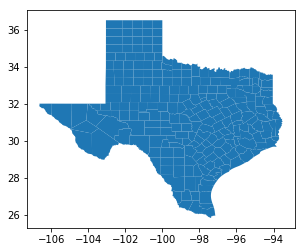

In [128]:
# make sure projection looks good
%matplotlib inline
merged_df.plot()

In [112]:
# write to file
# dosen't create a .prj file, so used the one from the original data
merged_df.to_file('data/counties_count.shp')

In [179]:
## values for GIS()
f = open('agol.csv')
username = str(f.readline())[:-1]
password = str(f.readline())[:-1]

In [178]:
# add to AGOL 
gis = GIS("https://www.arcgis.com", username, password)

tx_county_covid19_properties = {
    'title': 'TX Counties COVID19 Count',
    'tags': 'tx, open data',
    'type': 'Shapefile'
}

In [115]:
# load the shapefile
data_file_location = r'data/tx_counties_covid19.zip'
tx_county_covid19_shp = gis.content.add(tx_county_covid19_properties, data=data_file_location)

In [117]:
# call publish method, which returns another arcgis.gis.Item instance for the feature layer
tx_county_covid19_feature_layer_item = tx_county_covid19_shp.publish()

tx_county_covid19_feature_layer_item

<Item title:"TX Counties COVID19 Count" type:Feature Layer Collection owner:david.a.andresen_dev>


### The above workflow got the data on AGOL
### Below, the created feature layer will be updated daily

In [140]:
# access the layer to edit it
published_covid19 = gis.content.search('title:TX Counties COVID19 Count')
published_covid19_lyr = published_covid19[0].layers


In [143]:
# create a featureset to access the data
featureSet_published_covid19_lyr = published_covid19_lyr[0].query()

In [145]:
# create a pandas df to make updating eaiser
fset_df = featureSet_published_covid19_lyr.sdf
fset_df.columns

Index(['CNTY_NM', 'COUNT_', 'FID', 'OBJECTID', 'SHAPE', 'Shape__Area',
       'Shape__Length'],
      dtype='object')

In [180]:
# next will need to edit the above df and then publish again
# 
published_covid19_lyr[0].properties.capabilities

'Query'